In [4]:
import pandas as pd
import numpy as np

#seaborn이나 matplotlib 사용하기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time

#sklearn 라이브러리를 사용하기
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

%matplotlib inline
import matplotlib.gridspec as GridSpec

#pywt와  scipy라이브러리 사용하기
import pywt
from scipy import fftpack
from scipy import signal
from scipy import optimize
import itertools

In [5]:
#데이터 셋 불러오기(train 데이터, test 데이터, rul 데이터)
def prepare_data(dir_path):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    df_train = pd.read_csv(dir_path + 'train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv(dir_path + 'test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    y_true = pd.read_csv(dir_path + 'RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1

    return df_train, df_test, y_true

In [6]:
dir_path = '/Users/jinchan/edjjincode/NiseLabProject/Data/'

In [7]:
df_train, df_test, y_true = prepare_data(dir_path)
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [8]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:
index_names = ['UnitNumber', 'Cycle']
df_train[index_names].describe()

,UnitNumber,Cycle
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [10]:
df_train[index_names].groupby("UnitNumber").max().describe()

,Cycle
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [11]:
sensor_cols = [f"SensorMeasure{i}" for i in range(1, 22)]

In [12]:
df_train[sensor_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SensorMeasure1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
SensorMeasure2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
SensorMeasure3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
SensorMeasure4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
SensorMeasure5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
SensorMeasure6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
SensorMeasure7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
SensorMeasure8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
SensorMeasure9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
SensorMeasure10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


In [13]:
sc = MinMaxScaler(feature_range=(0,1))
df_train[sensor_cols] = sc.fit_transform(df_train[sensor_cols])
df_test[sensor_cols] = sc.transform(df_test[sensor_cols])

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

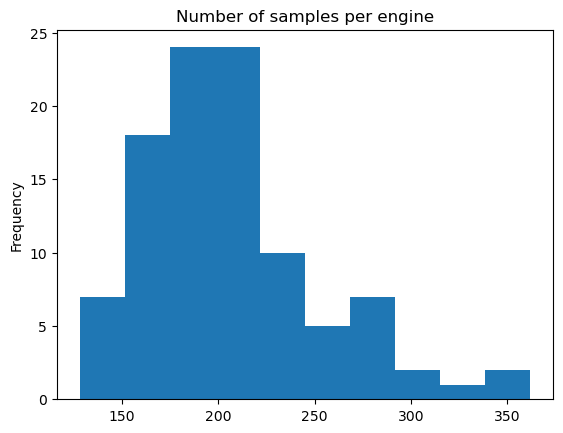

In [14]:
df_train.groupby("UnitNumber").size().plot(kind="hist")
plt.title("Number of samples per engine")
plt.show()

In [15]:
df_sensors = df_train[sensor_cols]

In [16]:
df_lag = df_train.groupby('UnitNumber').diff(1)
df_lag['UnitNumber'] = df_train['UnitNumber']
df_lag.dropna(inplace = True)
df_lag = df_lag.reset_index(drop = True)
df_lag.head()

,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL,UnitNumber
0,1.0,0.0026,0.0001,0.0,0.0,0.099398,0.046218,0.042876,0.0,0.0,...,-0.036794,0.047326,0.0,0.000000,0.0,0.0,-0.046512,0.006352,-1.0,1
1,1.0,-0.0062,0.0006,0.0,0.0,0.060241,-0.083497,0.017893,0.0,0.0,...,0.008979,-0.053867,0.0,-0.166667,0.0,0.0,-0.038760,-0.109638,-1.0,1
2,1.0,0.0050,-0.0003,0.0,0.0,0.000000,-0.113364,-0.039332,0.0,0.0,...,0.003096,-0.190843,0.0,0.166667,0.0,0.0,-0.054264,0.041011,-1.0,1
3,1.0,-0.0026,-0.0002,0.0,0.0,0.006024,0.001308,0.073430,0.0,0.0,...,-0.000155,0.235475,0.0,0.083333,0.0,0.0,0.015504,0.042115,-1.0,1
4,1.0,-0.0024,0.0001,0.0,0.0,-0.081325,0.035317,-0.132512,0.0,0.0,...,-0.004902,-0.071566,0.0,-0.166667,0.0,0.0,0.062016,-0.051781,-1.0,1


In [17]:
def monotonicity(data):

    num_pos = data[data > 0].shape[0]
    num_neg = data[data < 0].shape[0]
    tot_n = data.shape[0] - 1

    mon_val = np.abs(num_pos - num_neg)/tot_n
    return mon_val

In [18]:
mon_df = pd.DataFrame(columns = ['feature', 'monotonicity_val'])

for col in sensor_cols:
    mon_val = []
    for unit in df_lag.UnitNumber.unique():
        mon_val.append(monotonicity(df_lag.loc[df_lag.UnitNumber == unit, col]))
    mon_df = mon_df.append({'feature': col, 'monotonicity_val': np.mean(mon_val)}, ignore_index = True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
mon_df = mon_df.sort_values(by = 'monotonicity_val', ascending = False)
mon_df.head()

,feature,monotonicity_val
13,SensorMeasure14,0.052678
8,SensorMeasure9,0.045262
6,SensorMeasure7,0.044805
14,SensorMeasure15,0.038249
10,SensorMeasure11,0.038223


/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


ValueError: min() arg is an empty sequence

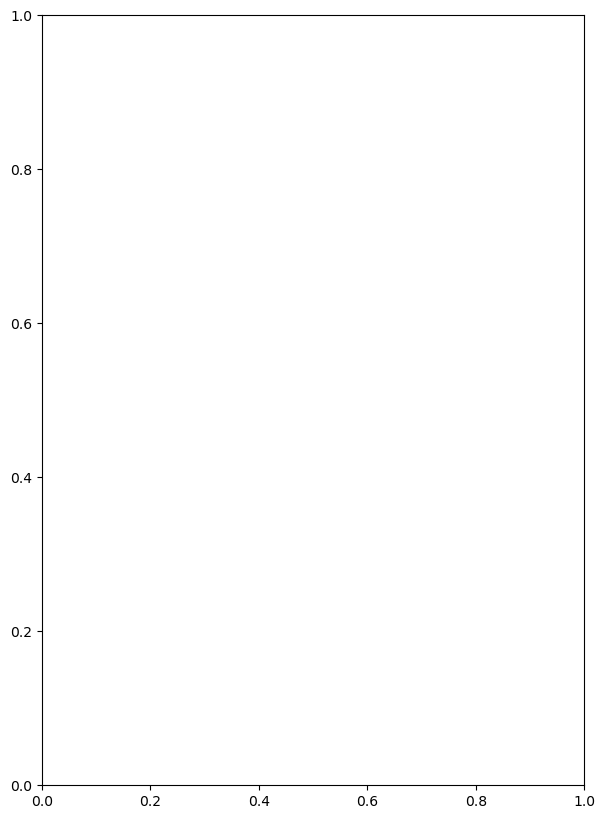

In [19]:
fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = mon_df.feature, x = mon_df.monotonicity_val)

In [ ]:
feats = mon_df.feature[mon_df.monotonicity_val > 0.035]
feats

13    SensorMeasure14
8      SensorMeasure9
6      SensorMeasure7
14    SensorMeasure15
10    SensorMeasure11
11    SensorMeasure12
1      SensorMeasure2
20    SensorMeasure21
3      SensorMeasure4
Name: feature, dtype: object

In [ ]:
len(feats)

9

In [ ]:
df = df_train[feats]

In [20]:
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

In [21]:
dwt_list = []
for i in range(len(feats)):
    dwt = lowpassfilter(df.iloc[:, i], 0.4)
    dwt_list.append(dwt)

NameError: name 'feats' is not defined

In [22]:
df_dwt = pd.DataFrame(dwt_list)

In [23]:
df_dwt = df_dwt.T

In [24]:
df_dwt

""


In [25]:
df_dwt

""


In [26]:
df_dwt.columns = df.columns

NameError: name 'df' is not defined

In [27]:
df_dwt

""


In [28]:
df_1 = df_train["UnitNumber"]

In [29]:
df = pd.concat([df_1, df_dwt], axis = 1)

ValueError: cannot concatenate unaligned mixed dimensional NDFrame objects

In [ ]:
df

,UnitNumber,SensorMeasure14,SensorMeasure9,SensorMeasure7,SensorMeasure15,SensorMeasure11,SensorMeasure12,SensorMeasure2,SensorMeasure21,SensorMeasure4
0,1.0,0.194727,0.164045,0.543752,0.472216,0.426373,0.554121,0.454180,0.542153,0.458215
1,1.0,0.194579,0.163916,0.567716,0.448886,0.390723,0.585377,0.442679,0.559857,0.433588
2,1.0,0.194424,0.163780,0.593993,0.422287,0.351107,0.620548,0.430545,0.578788,0.406529
3,1.0,0.194290,0.163663,0.613922,0.403253,0.321811,0.646156,0.420683,0.593750,0.386070
4,1.0,0.194176,0.163561,0.626659,0.392282,0.304281,0.661064,0.413411,0.604057,0.373110
...,...,...,...,...,...,...,...,...,...,...
20627,100.0,0.195449,0.164675,0.455767,0.552696,0.550041,0.448259,0.501927,0.473380,0.547831
20628,100.0,0.195329,0.164570,0.469627,0.542623,0.531108,0.463279,0.493592,0.485396,0.533634
20629,100.0,0.195188,0.164448,0.485178,0.529152,0.509820,0.481143,0.484665,0.497977,0.517845
20630,100.0,0.195009,0.164292,0.502415,0.510277,0.486406,0.502451,0.475268,0.510479,0.500548


In [30]:
df_2 = df_train[["Cycle", "RUL"]]

In [31]:
df_new = pd.concat([df, df_2], axis = 1)

NameError: name 'df' is not defined

In [32]:
df_new

NameError: name 'df_new' is not defined

In [33]:
df_new.dropna(inplace = True)

NameError: name 'df_new' is not defined

In [34]:
from sklearn.decomposition import PCA

In [35]:

pca = PCA(n_components=3)

pca_data = pca.fit_transform(df_new[feats])

pca_df = pd.DataFrame(pca_data, columns = ['pc1', 'pc2', 'pc3'])
pca_df['UnitNumber'] = df_new.UnitNumber.values
pca_df['cycle'] = pca_df.groupby('UnitNumber').cumcount()+1
pca_df['RUL'] = pca_df.groupby('UnitNumber').cycle.transform('max') - pca_df.cycle
pca_df.head()

NameError: name 'df_new' is not defined

In [36]:
pcs = ['pc1', 'pc2', 'pc3']

In [37]:
sns.pairplot(data = pca_df[pca_df.UnitNumber == 1], x_vars= pcs, y_vars = pcs)

NameError: name 'pca_df' is not defined

NameError: name 'pca_df' is not defined

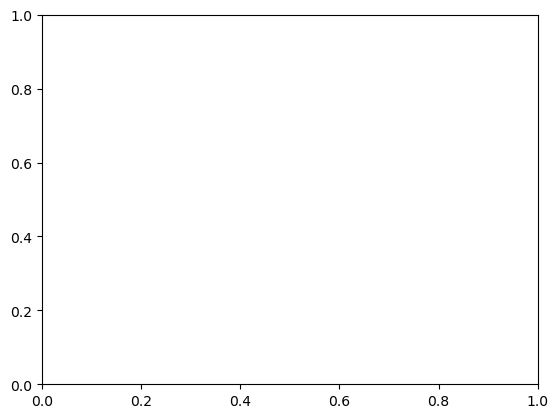

In [38]:
fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "cycle", y = "pc1", ax = ax)
plt.axhline(pca_df[pca_df.UnitNumber == 1].pc1.max(), color = 'r')
ax.set_ylabel("Health Indicator")

NameError: name 'pca_df' is not defined

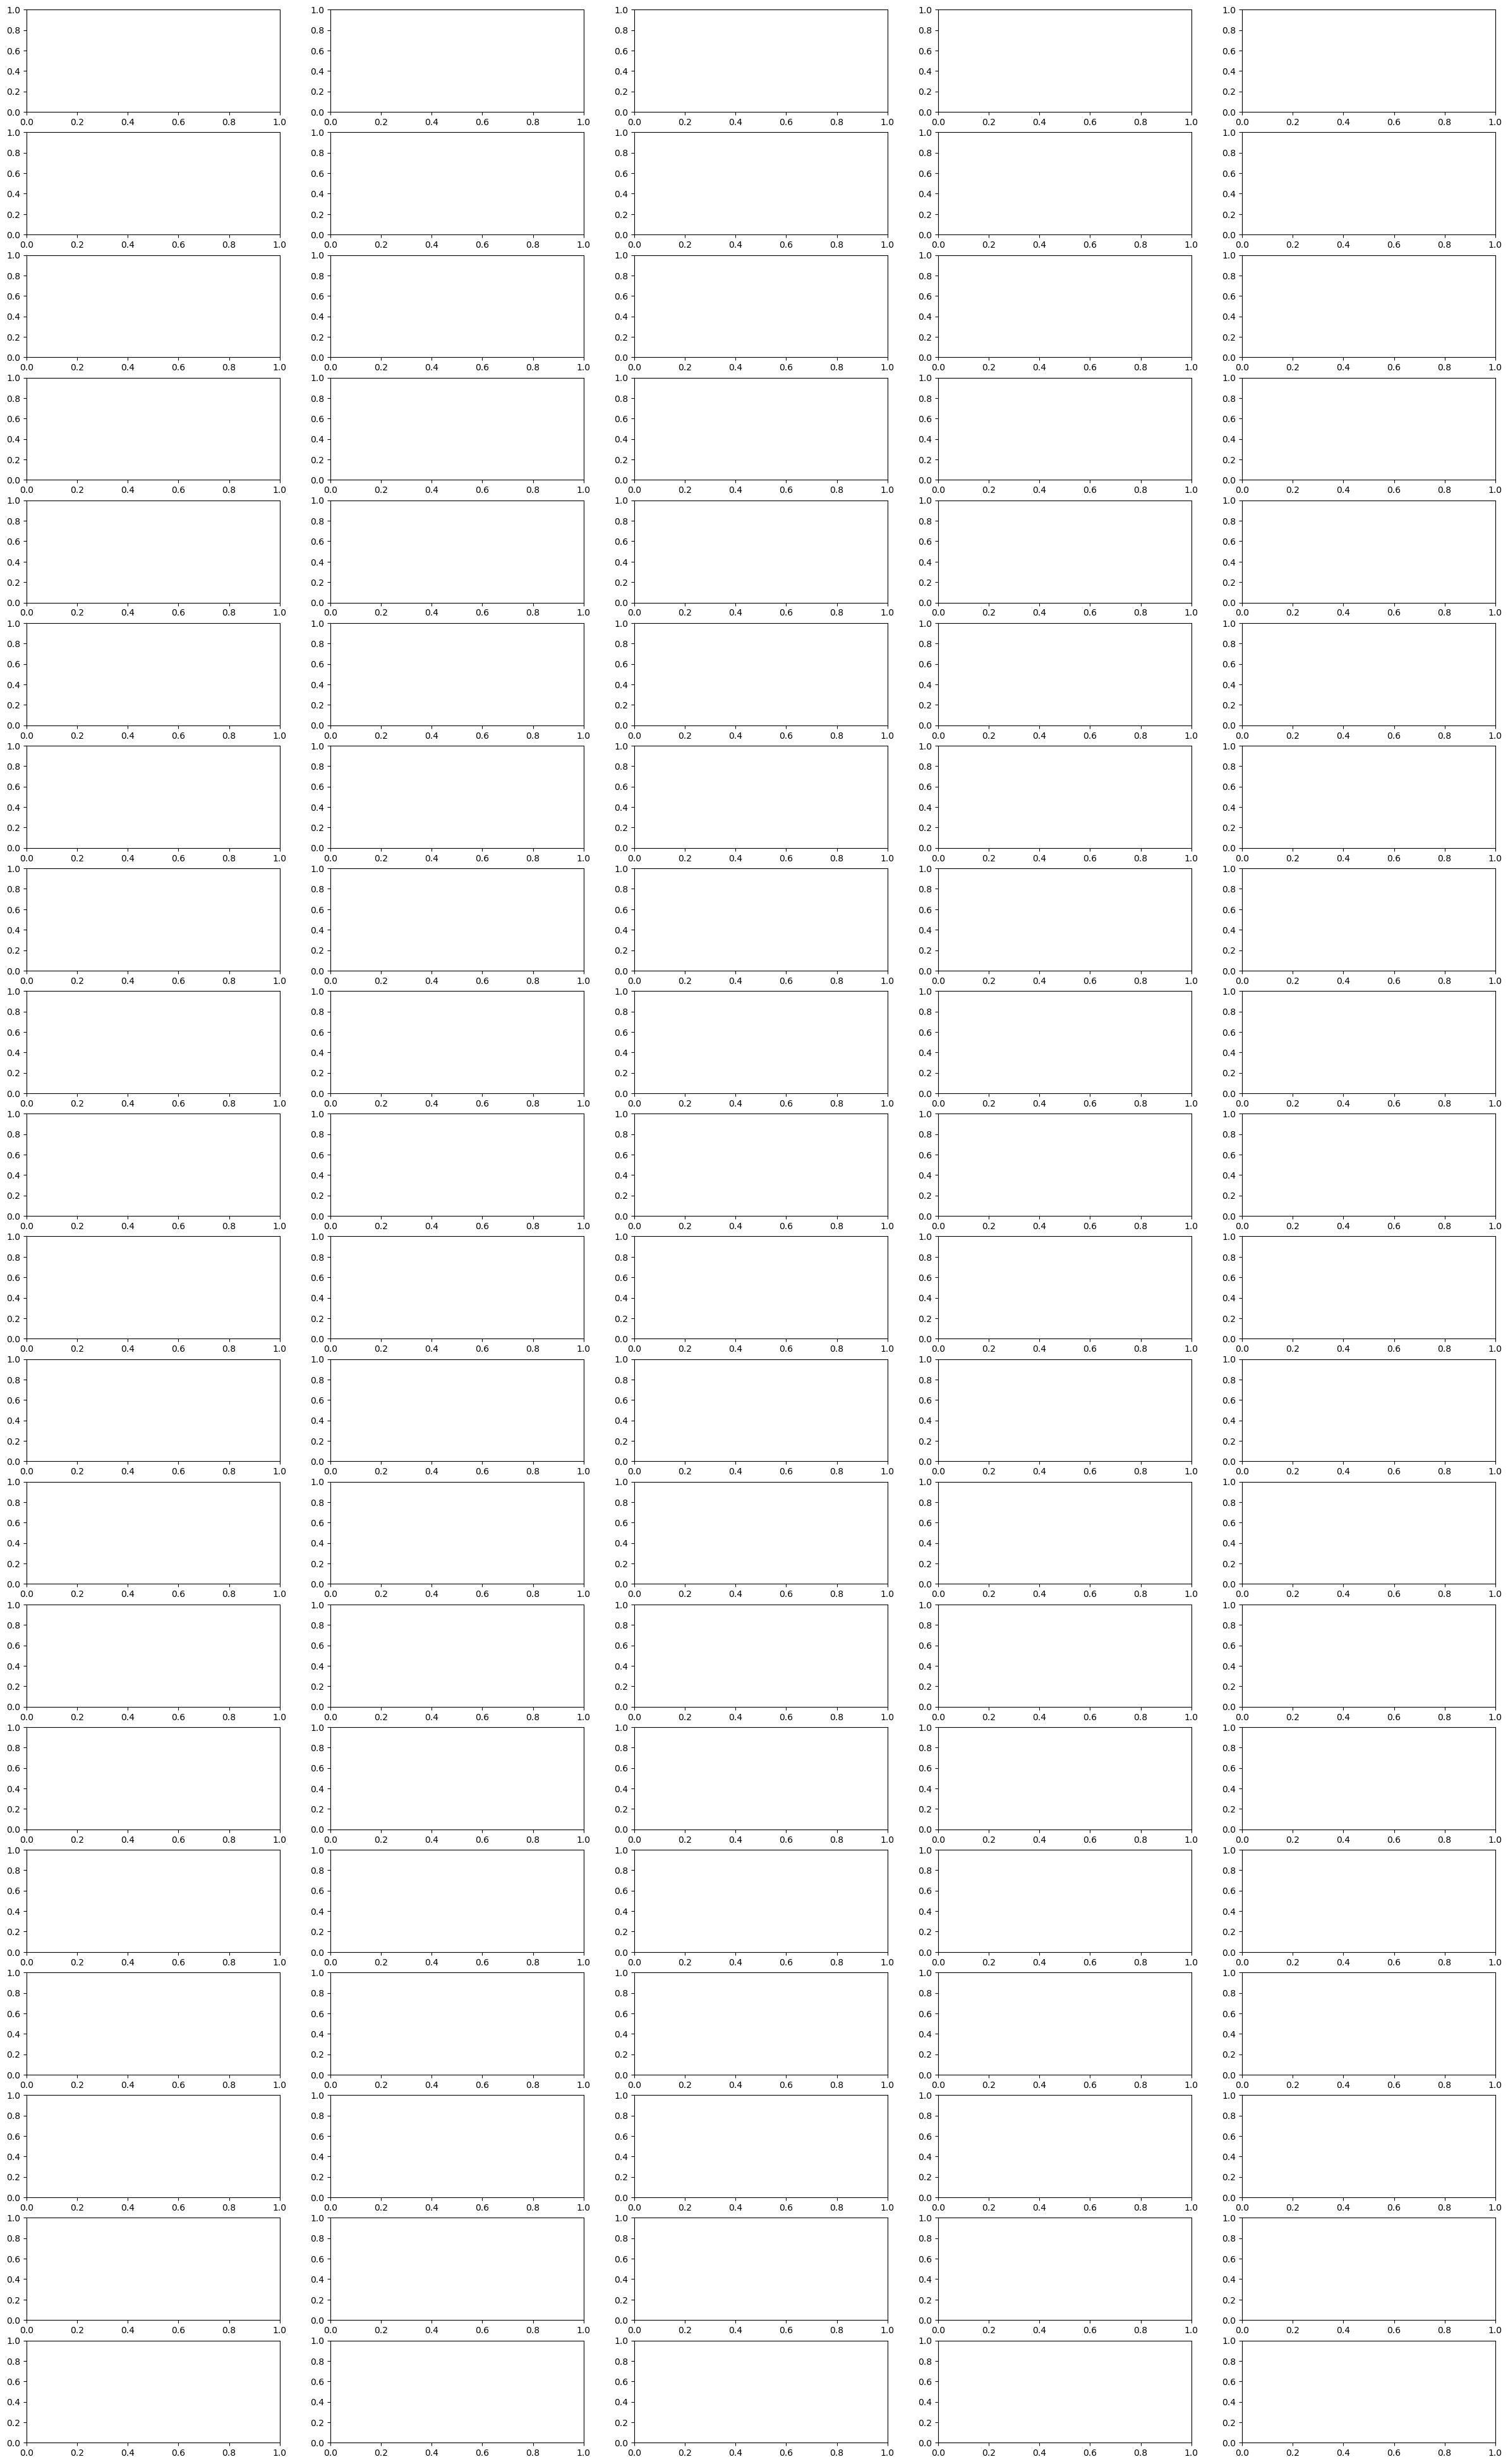

In [39]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    ax[i].axhline(pca_df[pca_df.UnitNumber == i+1].pc1.max(), color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

<ipython-input-42-987ce87277a4>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pca_df.pc1[pca_df.RUL == 0], label= "RUL: 0")
<ipython-input-42-987ce87277a4>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pca_df.pc1[pca_df.RUL == 30], label= "RUL: 30")
<ipython-input-42-987ce87277a4>:4: UserW

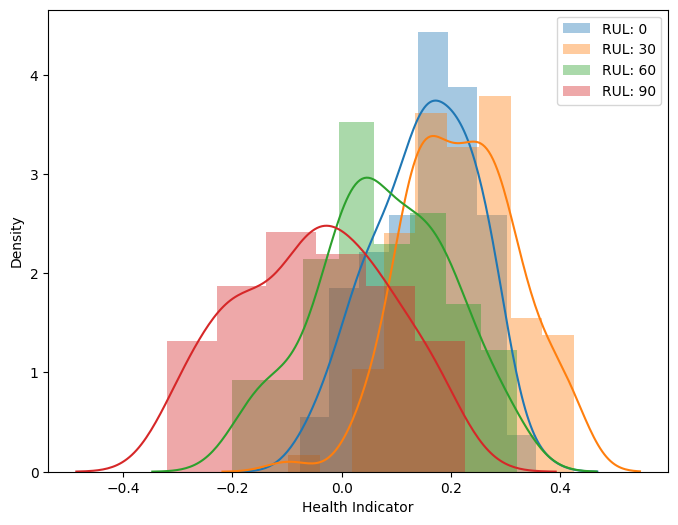

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.distplot(pca_df.pc1[pca_df.RUL == 0], label= "RUL: 0")
sns.distplot(pca_df.pc1[pca_df.RUL == 30], label= "RUL: 30")
sns.distplot(pca_df.pc1[pca_df.RUL == 60], label= "RUL: 60")
sns.distplot(pca_df.pc1[pca_df.RUL == 90], label= "RUL: 90")
plt.xlabel("Health Indicator")
plt.legend()
plt.show()

In [ ]:
threshold = pca_df.pc1[pca_df.RUL == 0].mean()
threshold

0.15171862717207102

In [ ]:
threshold_std = pca_df.pc1[pca_df.RUL == 0].std()
threshold_std

0.09367858370032228

<ipython-input-45-800857fa65b1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pca_df.pc1[pca_df.RUL == 0])


<Axes: xlabel='pc1', ylabel='Density'>

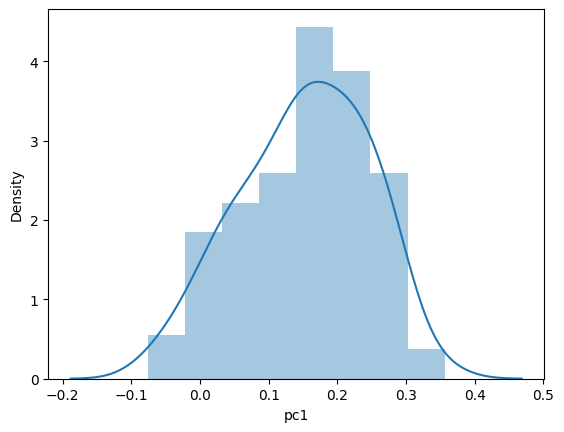

In [ ]:
sns.distplot(pca_df.pc1[pca_df.RUL == 0])

In [ ]:
def exp_degradation(parameters, cycle):
    '''
    Calculate an exponetial degradation of the form:
    ht = phi + theta * exp(beta * cycle)
    '''
    phi = parameters[0]
    theta = parameters[1]
    beta = parameters[2]

    ht = phi + theta * np.exp(beta * cycle)
    return ht

In [ ]:
def residuals(parameters, data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters, data) - y_observed

In [ ]:
param_0 = [-1, 0.01, 0.01]

In [ ]:
exp_params_df = pd.DataFrame(columns = ['UnitNumber', 'phi', 'theta', 'beta'])

for i in range(1,101):

    ht = pca_df.pc1[pca_df.UnitNumber == i]
    cycle = pca_df.cycle[pca_df.UnitNumber == i]

    OptimizeResult = optimize.least_squares(residuals, param_0, args = (cycle, ht, exp_degradation))
    phi, theta, beta = OptimizeResult.x

    exp_params_df = exp_params_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta}, ignore_index = True)

<ipython-input-49-a47c6d4ccc3d>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp_params_df = exp_params_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta}, ignore_index = True)
<ipython-input-49-a47c6d4ccc3d>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp_params_df = exp_params_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta}, ignore_index = True)
<ipython-input-49-a47c6d4ccc3d>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp_params_df = exp_params_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta}, ignore_index = True)
<ipython-input-49-a47c6d4ccc3d>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

In [40]:
exp_params_df.head()

NameError: name 'exp_params_df' is not defined

In [41]:
phi = exp_params_df.phi[exp_params_df.UnitNumber == 1].values
theta = exp_params_df.theta[exp_params_df.UnitNumber == 1].values
beta = exp_params_df.beta[exp_params_df.UnitNumber == 1].values

cycles = pca_df.cycle[pca_df.UnitNumber == 1]
pred_ht = exp_degradation([phi, theta, beta], cycles)

fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "cycle", y = "pc1", ax = ax, label = "True HI")
sns.lineplot(y = pred_ht, x = cycles, ax = ax, color = "green", label = "Fitted Exponential HI")
ax.axhline(threshold, color = 'r')
ax.text(200,threshold - 0.01,'Failure Threshold',rotation=0)
ax.set_title("Unit: 1")
ax.set_xlabel("Cycles")
ax.set_ylabel("Health Indicator")

NameError: name 'exp_params_df' is not defined

NameError: name 'exp_params_df' is not defined

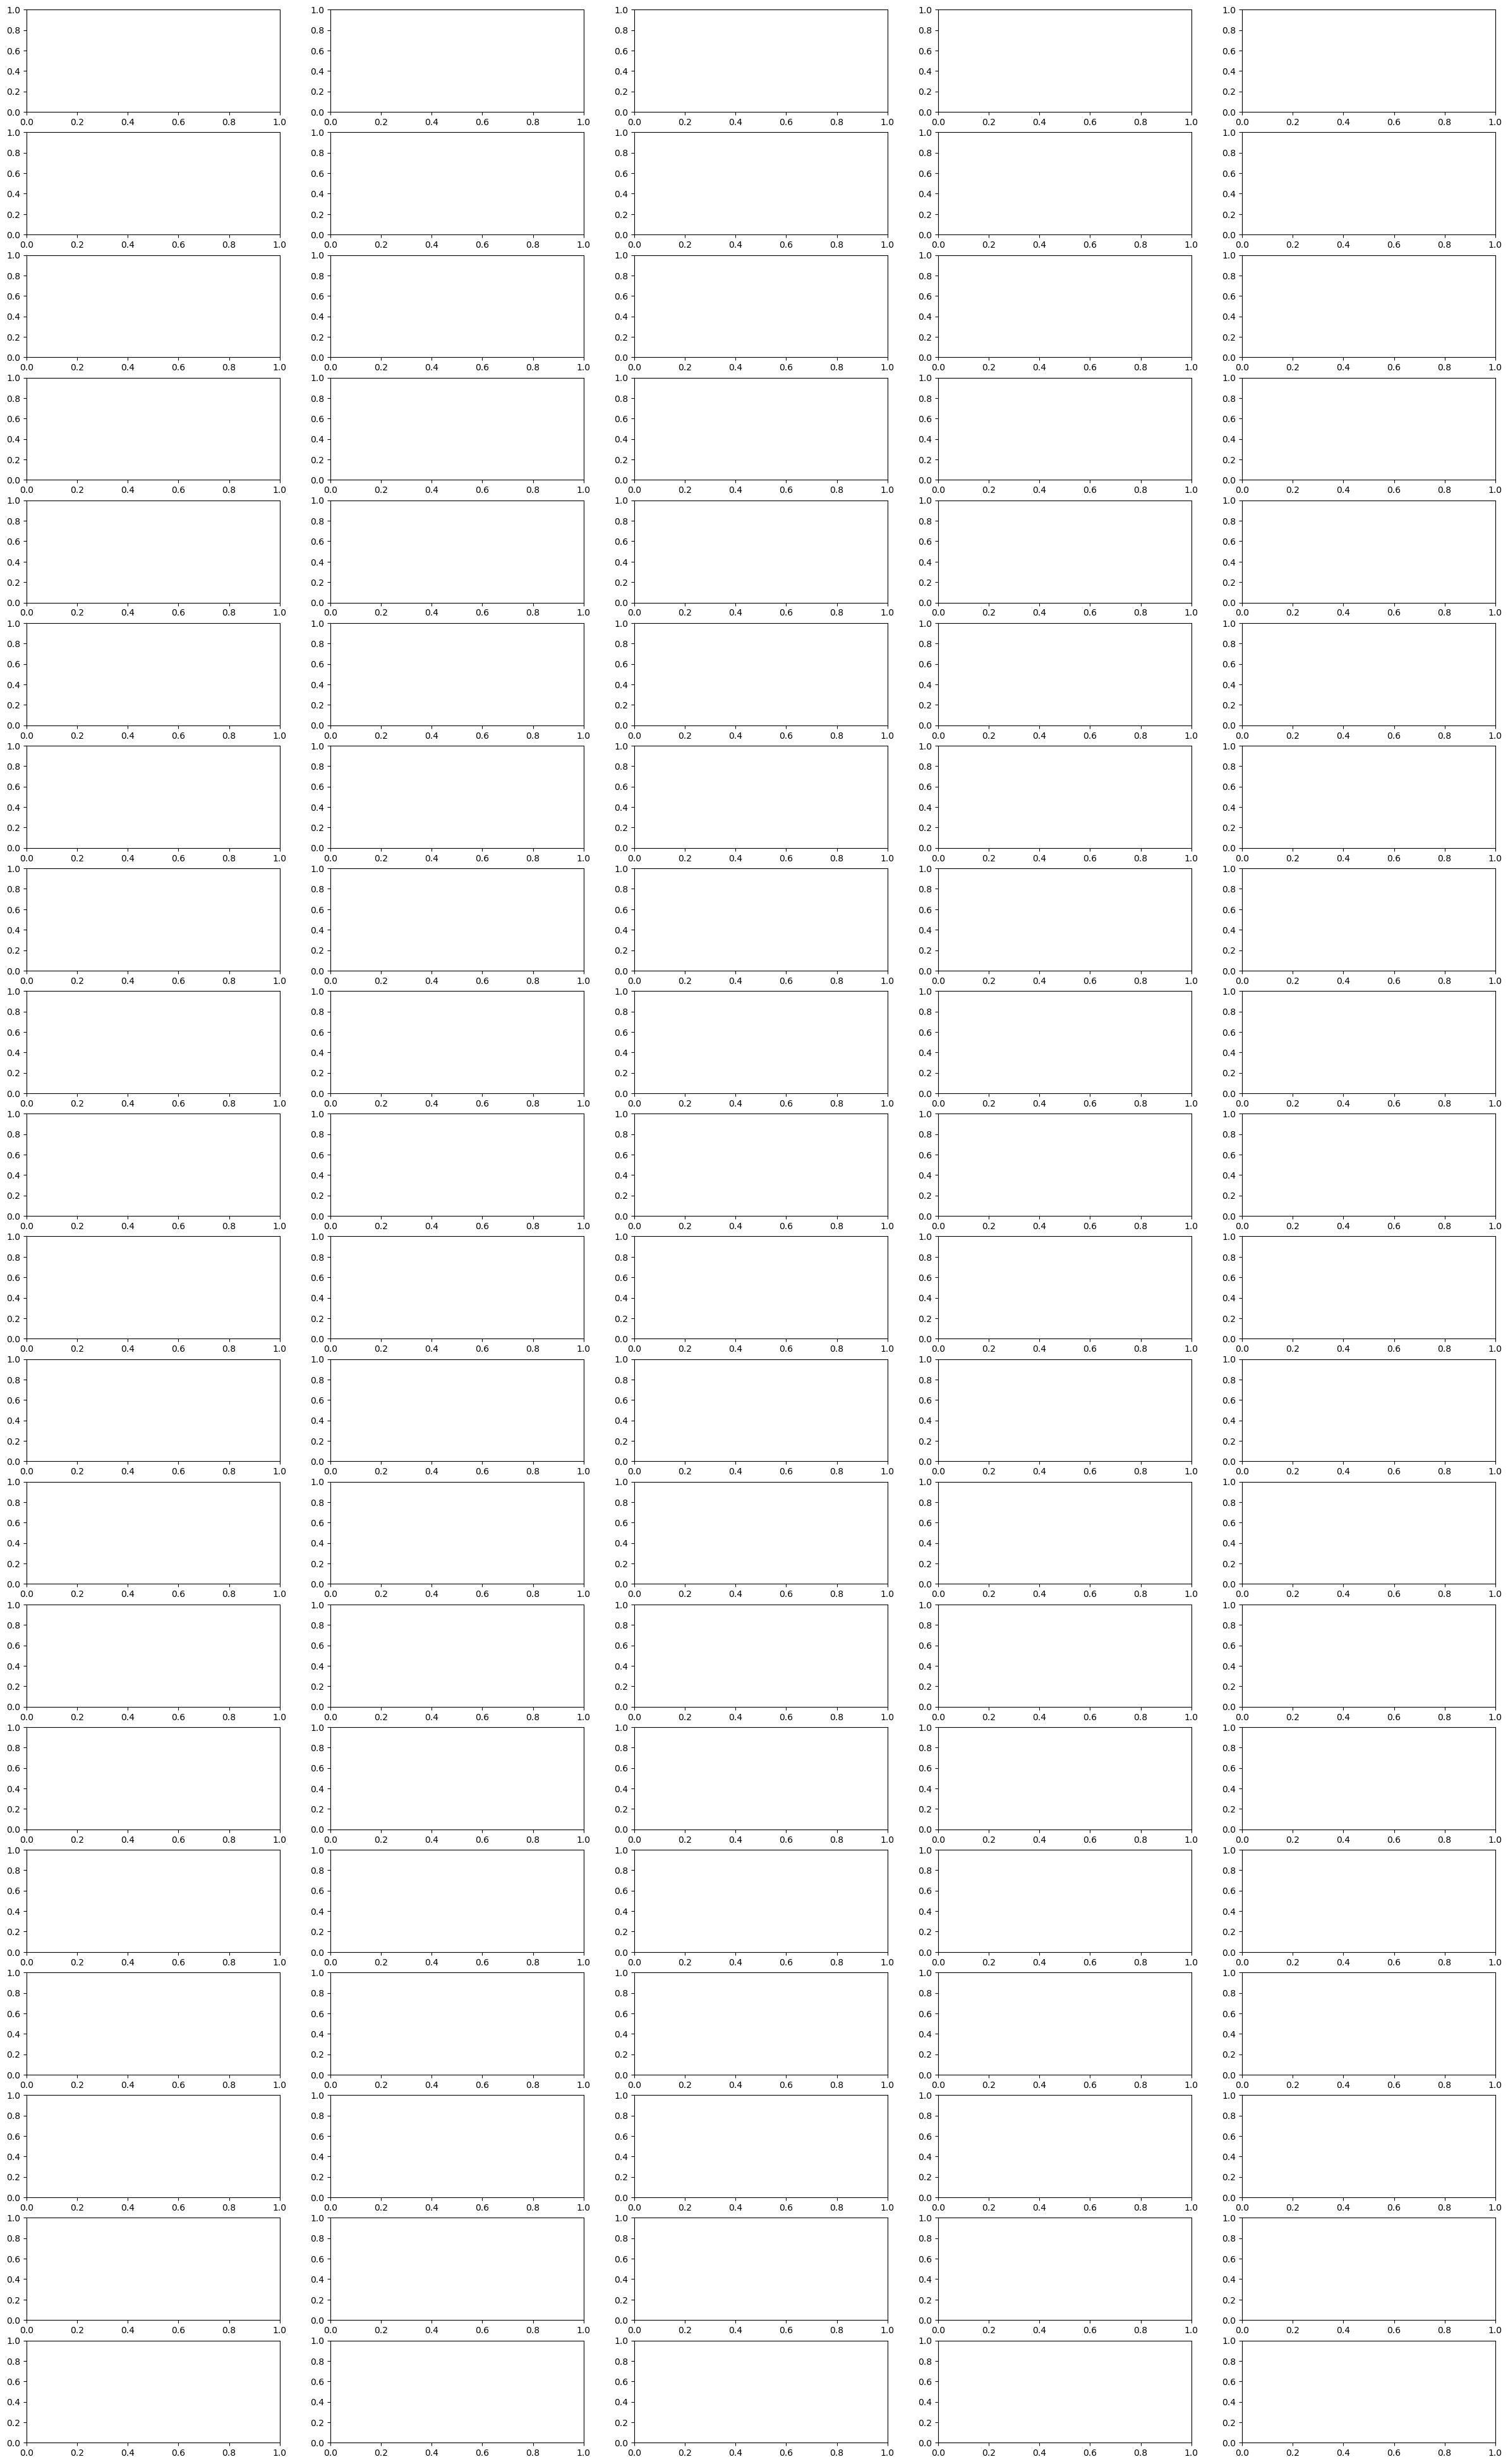

In [42]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):

    phi = exp_params_df.phi[exp_params_df.UnitNumber == i+1].values
    theta = exp_params_df.theta[exp_params_df.UnitNumber == i+1].values
    beta = exp_params_df.beta[exp_params_df.UnitNumber == i+1].values

    cycles = pca_df.cycle[pca_df.UnitNumber == i+1]
    pred_ht = exp_degradation([phi, theta, beta], cycles)

    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    sns.lineplot(y = pred_ht, x = cycles, ax = ax[i], color = "green")
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

<ipython-input-53-4c7c6880793b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp_params_df.phi, ax = ax[0])
<ipython-input-53-4c7c6880793b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp_params_df.theta, ax = ax[1], color = "red")
<ipython-input-53-4c7c6880793b>:4: UserWarning: 

`dist

<Axes: xlabel='beta', ylabel='Density'>

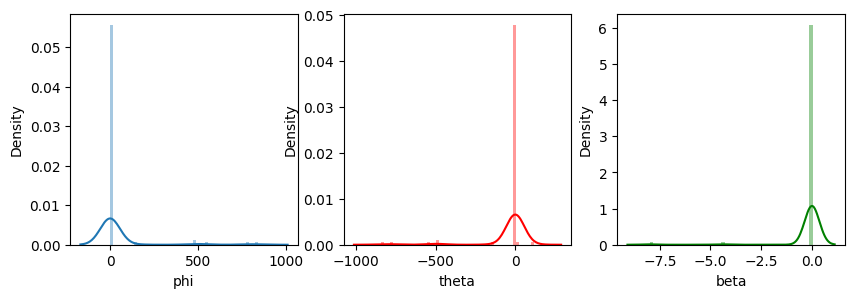

In [ ]:
fig, ax = plt.subplots(figsize = (10,3), nrows = 1, ncols = 3)
sns.distplot(exp_params_df.phi, ax = ax[0])
sns.distplot(exp_params_df.theta, ax = ax[1], color = "red")
sns.distplot(exp_params_df.beta, ax = ax[2], color = "green")

In [ ]:
dwt_test_list = []
for i in range(len(feats)):
    dwt = lowpassfilter(df_test[feats].iloc[:, i], 0.4)
    dwt_test_list.append(dwt)

In [ ]:
df_test_dwt = pd.DataFrame(dwt_test_list)

In [ ]:
df_test_dwt  = df_test_dwt.T

In [ ]:
df_test_dwt

,0,1,2,3,4,5,6,7,8
0,0.243593,0.204130,0.608451,0.409172,0.352927,0.628205,0.398906,0.587938,0.400028
1,0.206536,0.165484,0.607930,0.408231,0.350207,0.627353,0.390096,0.587449,0.395158
2,0.186545,0.147265,0.607360,0.407298,0.347458,0.626434,0.380361,0.586920,0.389819
3,0.159226,0.119190,0.606884,0.406501,0.345129,0.625659,0.373249,0.586474,0.385870
4,0.132000,0.089719,0.606499,0.405849,0.343245,0.625029,0.369412,0.586110,0.383646
...,...,...,...,...,...,...,...,...,...
13091,0.378249,0.345391,0.610675,0.413816,0.365953,0.631951,0.426214,0.590077,0.415851
13092,0.366246,0.333915,0.610294,0.412998,0.363706,0.631294,0.421337,0.589701,0.413027
13093,0.351770,0.319776,0.609880,0.412082,0.361164,0.630588,0.416760,0.589298,0.410316
13094,0.334622,0.302609,0.609379,0.411052,0.358247,0.629753,0.413599,0.588824,0.408278


In [ ]:
df_test_dwt.columns = feats

In [ ]:
df_test_dwt

feature,SensorMeasure14,SensorMeasure9,SensorMeasure7,SensorMeasure15,SensorMeasure11,SensorMeasure12,SensorMeasure2,SensorMeasure21,SensorMeasure4
0,0.243593,0.204130,0.608451,0.409172,0.352927,0.628205,0.398906,0.587938,0.400028
1,0.206536,0.165484,0.607930,0.408231,0.350207,0.627353,0.390096,0.587449,0.395158
2,0.186545,0.147265,0.607360,0.407298,0.347458,0.626434,0.380361,0.586920,0.389819
3,0.159226,0.119190,0.606884,0.406501,0.345129,0.625659,0.373249,0.586474,0.385870
4,0.132000,0.089719,0.606499,0.405849,0.343245,0.625029,0.369412,0.586110,0.383646
...,...,...,...,...,...,...,...,...,...
13091,0.378249,0.345391,0.610675,0.413816,0.365953,0.631951,0.426214,0.590077,0.415851
13092,0.366246,0.333915,0.610294,0.412998,0.363706,0.631294,0.421337,0.589701,0.413027
13093,0.351770,0.319776,0.609880,0.412082,0.361164,0.630588,0.416760,0.589298,0.410316
13094,0.334622,0.302609,0.609379,0.411052,0.358247,0.629753,0.413599,0.588824,0.408278


In [ ]:
df_3 = df_test["UnitNumber"]

In [ ]:
df_dwt = pd.concat([df_3, df_test_dwt], axis = 1)

In [ ]:
df_2 = df_test["Cycle"]

In [ ]:
df_new_test = pd.concat([df, df_2], axis = 1)

In [ ]:
pca_test_data = pca.transform(df_new_test[feats])

pca_test_df = pd.DataFrame(pca_test_data, columns = ['pc1', 'pc2', 'pc3'])
pca_test_df['UnitNumber'] = df_new_test.UnitNumber.values
pca_test_df['Cycle'] = pca_test_df.groupby('UnitNumber').cumcount()+1
pca_test_df.head()

,pc1,pc2,pc3,UnitNumber,Cycle
0,0.040162,-0.047077,-0.000624,1.0,1.0
1,-0.024982,-0.044652,0.010225,1.0,2.0
2,-0.097076,-0.041882,0.022943,1.0,3.0
3,-0.150976,-0.039931,0.031487,1.0,4.0
4,-0.184388,-0.038912,0.035285,1.0,5.0


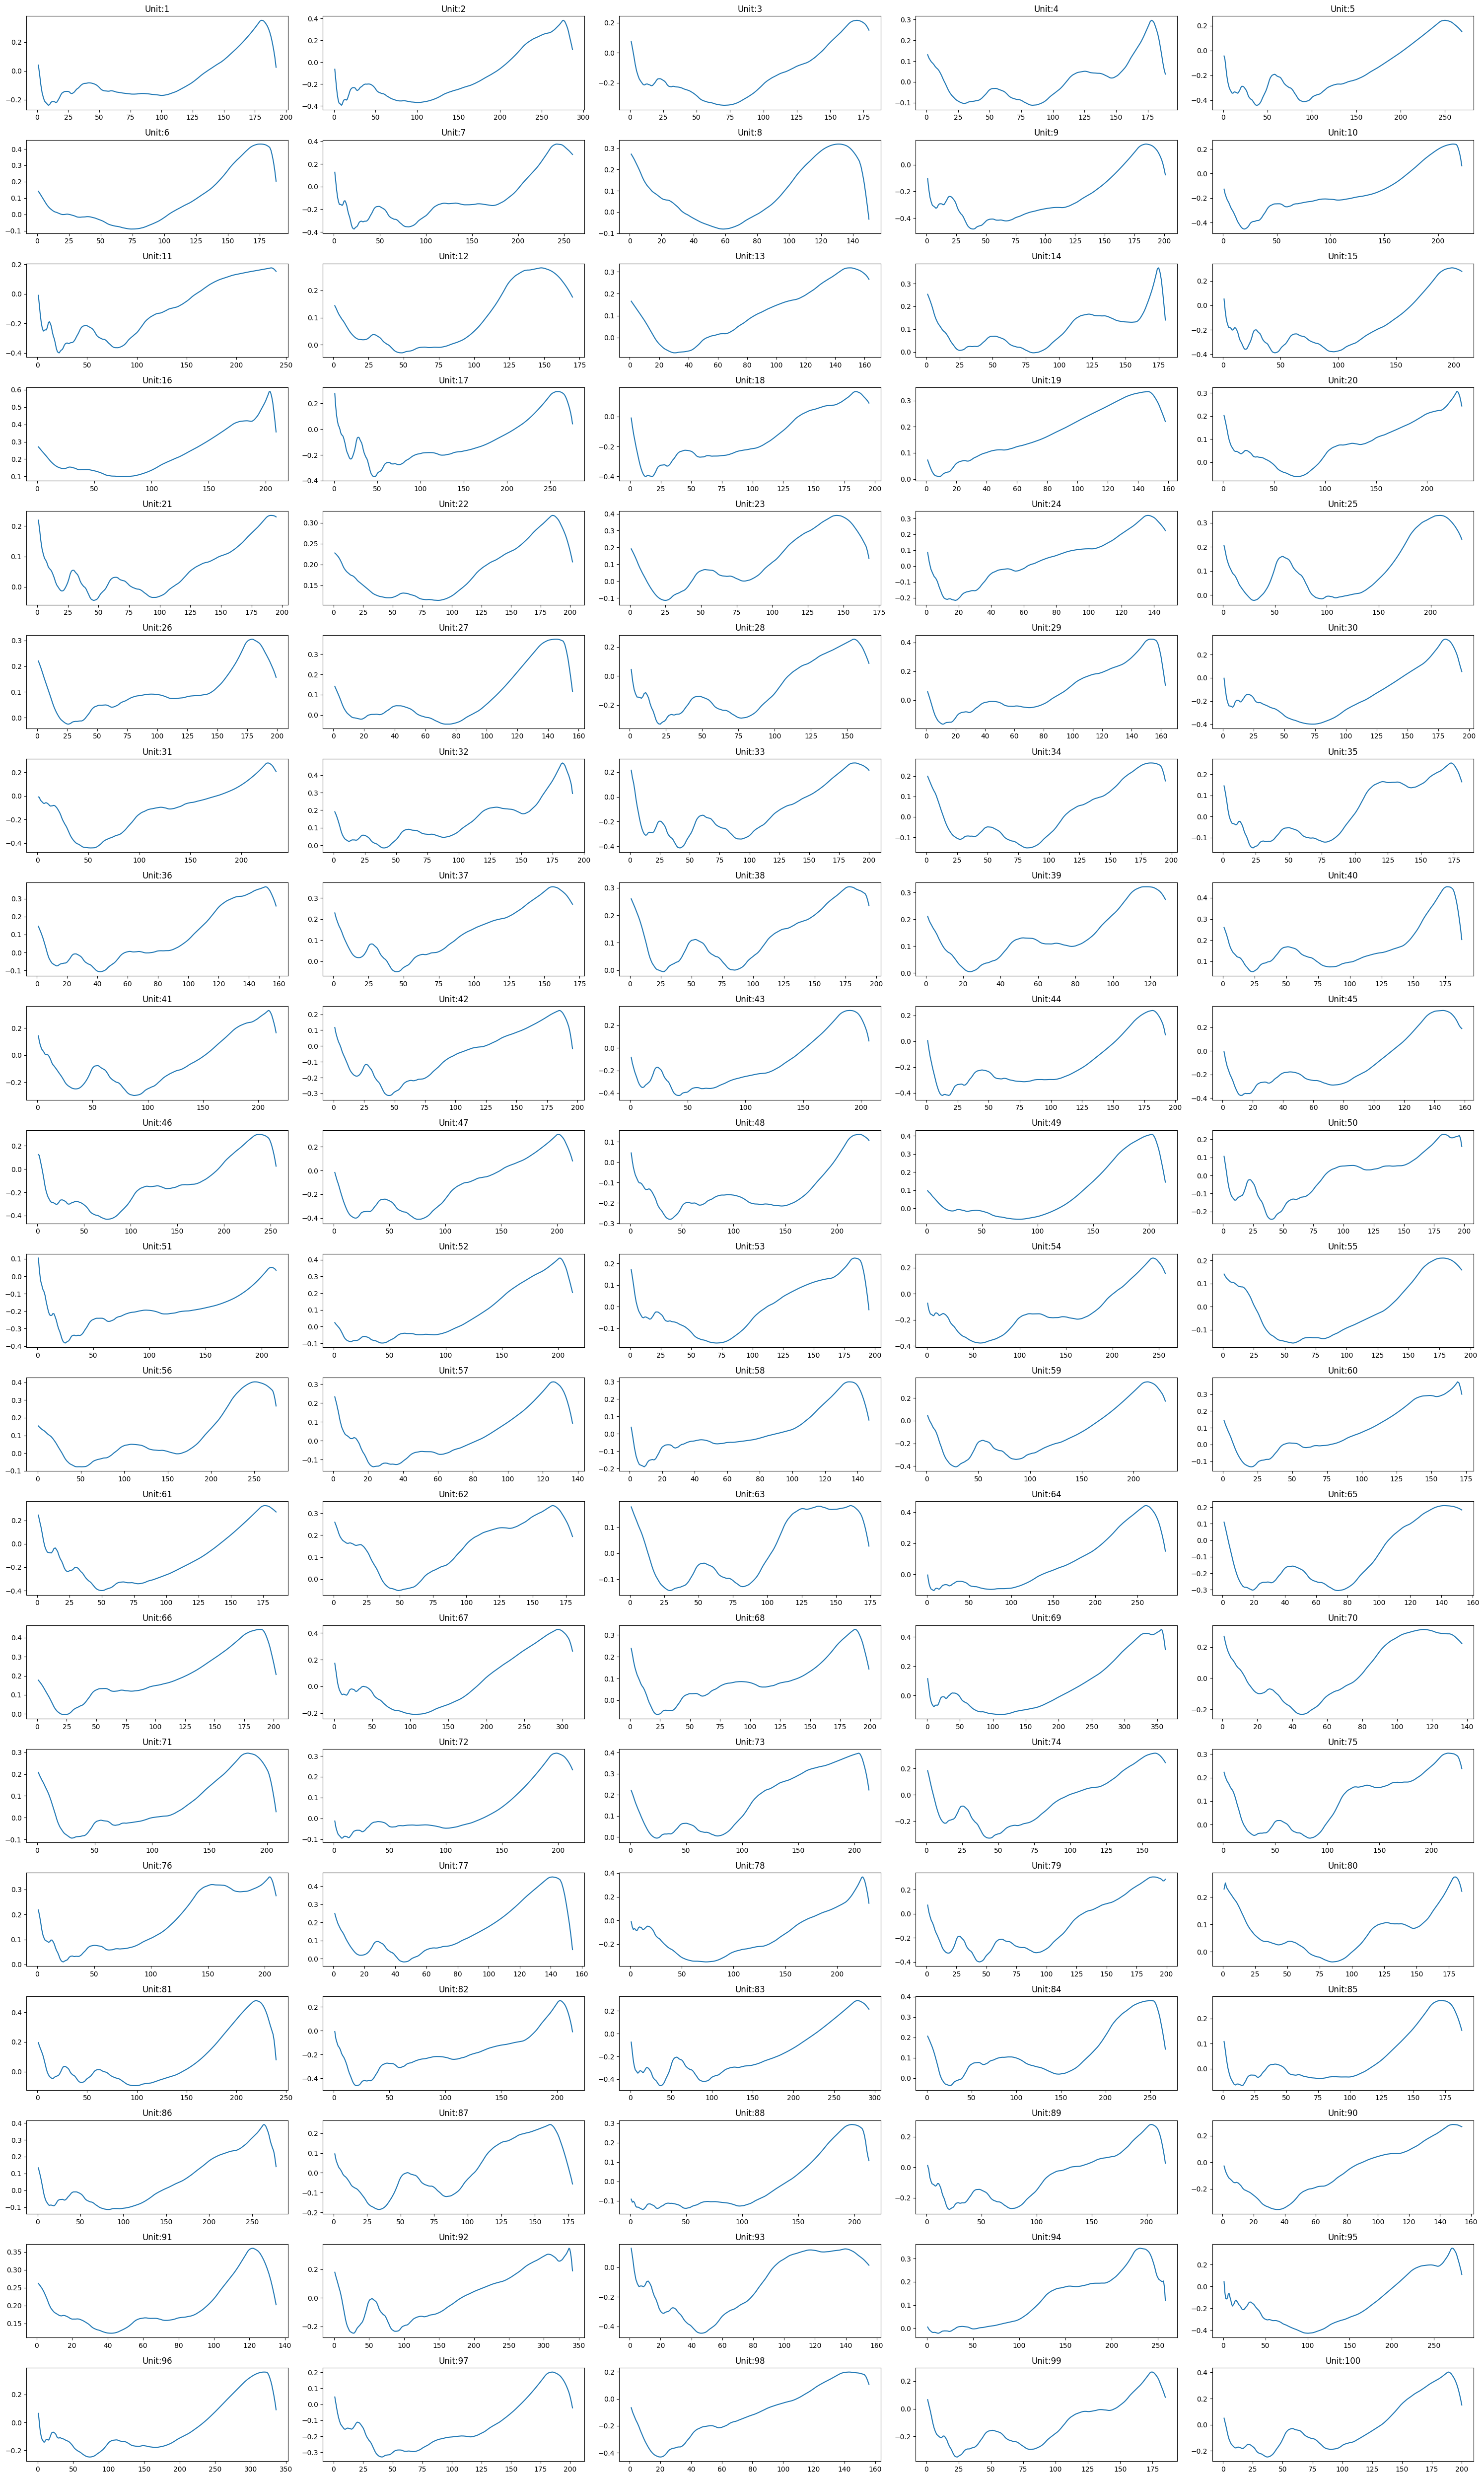

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):

    sns.lineplot(data = pca_test_df[pca_test_df.UnitNumber == i+1], x = "Cycle", y = "pc1", ax = ax[i])
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

In [ ]:
phi_vals = exp_params_df.phi
theta_vals = exp_params_df.theta
beta_vals = exp_params_df.beta

In [ ]:
phi_vals.mean()

32.518836613975424

In [ ]:
param_1 = [phi_vals.mean(), theta_vals.mean(), beta_vals.mean()]
param_1

[32.518836613975424, -31.44298126062037, -0.10958792067988368]

In [ ]:
lb = 25
ub = 75
phi_bounds = [np.percentile(phi_vals, lb), np.percentile(phi_vals, ub)]
theta_bounds = [np.percentile(theta_vals, lb), np.percentile(theta_vals, ub)]
beta_bounds = [np.percentile(beta_vals, lb), np.percentile(beta_vals, ub)]

In [ ]:
bounds = ([phi_bounds[0], theta_bounds[0], beta_bounds[0]],
          [phi_bounds[1], theta_bounds[1], beta_bounds[1]])
bounds

([-0.2779571778242013, 0.009558979888760801, 0.010902547986582129],
 [-0.016971413255517015, 0.03967523467365209, 0.01890506298178391])

In [ ]:
result_test_df = pd.DataFrame(columns = ['UnitNumber', 'phi', 'theta', 'beta', 'Pred_RUL', 'True_RUL'])

for i in pca_test_df.UnitNumber.unique():

    ht = pca_test_df.pc1[pca_test_df.UnitNumber == i]
    cycle = pca_test_df.Cycle[pca_test_df.UnitNumber == i]

    OptimizeResult = optimize.least_squares(residuals, param_1, bounds=bounds,
                                            args = (cycle, ht, exp_degradation))
    phi, theta, beta = OptimizeResult.x
    total_cycles = np.log((threshold - phi) / theta) / beta
    RUL = total_cycles - cycle.max()

    result_test_df = result_test_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta,
                                         'Pred_RUL': RUL, 'True_RUL': y_true.RUL[y_true.UnitNumber == i].values[0]},
                                         ignore_index = True)

ValueError: ignored

In [ ]:
result_test_df.head()

,UnitNumber,phi,theta,beta,Pred_RUL,True_RUL


In [ ]:
sns.regplot(x = result_test_df.Pred_RUL, y = result_test_df.True_RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = result_test_df.UnitNumber, y = result_test_df.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = result_test_df.UnitNumber, y = result_test_df.True_RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):

    phi = result_test_df.phi[result_test_df.UnitNumber == i+1].values[0]
    theta = result_test_df.theta[result_test_df.UnitNumber == i+1].values[0]
    beta = result_test_df.beta[result_test_df.UnitNumber == i+1].values[0]
    Pred_RUL = result_test_df.Pred_RUL[result_test_df.UnitNumber == i+1].values[0]

    cycles = pca_test_df.cycle[pca_test_df.UnitNumber == i+1]
    total_cycles = [j for j in range(1, int(cycles.max() + Pred_RUL + 1))]
    pred_ht = exp_degradation([phi, theta, beta], pd.Series(total_cycles))

    sns.lineplot(data = pca_test_df[pca_test_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    sns.lineplot(y = pred_ht, x = total_cycles, ax = ax[i], color = "green")
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

In [ ]:
mean_squared_error(result_test_df.True_RUL, result_test_df.Pred_RUL)

In [ ]:
mean_absolute_error(result_test_df.True_RUL, result_test_df.Pred_RUL)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(result_test_df.True_RUL, result_test_df.Pred_RUL)